In [1]:
%load_ext autoreload
%autoreload 2
import warnings
import numpy as np
import time
import os
from dotenv import load_dotenv
os.environ["USE_PYGEOS"] = "0"
import napari_sparrow as nas
from spatialdata import read_zarr
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
%run own_and_modified_functions.ipynb
warnings.simplefilter(action='ignore')

the value of the environment variable BASIC_DCT_BACKEND is not in ["JAX","SCIPY"]


In [2]:
OUTPUT_DIR = '/home/wout/Documents/Thesis_lokaal/Mouse_Liver_Resolve_Data'
sdata = read_zarr( os.path.join(  OUTPUT_DIR, 'sdata.zarr'  ) )
anndata = sc.read('/home/wout/Documents/Thesis_lokaal/Mouse_Liver_Resolve_Data/anndataNucA11') # reset original anndata
# delete anndata
del sdata.table
# create anndata
sdata.table = anndata

In [3]:
# count the number of principal components that explain at least 1% of the variance
n_pca = np.count_nonzero(sdata.table.uns['pca']['variance_ratio'] > 0.01)
n_pca
# play with the number of neighbors 
# Larger values result in more global views of the manifold, while smaller values result in more local data being preserved. 
# In general values should be in the range 2 to 100, default = 15
n_neighb = 15
# play with the cluster resolution
# A parameter value controlling the coarseness of the clustering. Higher values lead to more clusters. default = 1 
n_clust_res = 1
path_mg = "/home/wout/Documents/Thesis_lokaal/Mouse_Liver_Resolve_Data/markerGeneListBasic.csv"

0.25


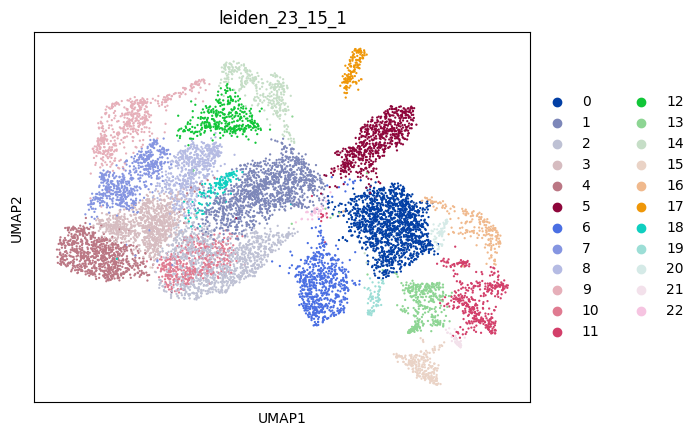

    leiden_23_15_1
0         0.126024
1         0.107143
2         0.097257
3         0.081315
4         0.073566
5         0.059227
6         0.056733
7         0.052547
8         0.051300
9         0.044888
10        0.037496
11        0.036961
12        0.032419
13        0.031439
14        0.028678
15        0.021642
16        0.018080
17        0.013270
18        0.011845
19        0.005967
20        0.005166
21        0.003741
22        0.003295
{'B cell': ['17'], 'Chol': ['15'], 'Endo vein/LSEC(58%/42%)': ['16'], 'Fibr/B cell(58%/42%)': ['21'], 'Hepa': ['1', '2', '3', '4', '7', '8', '9', '10', '12', '14', '18'], 'Kupf': ['5', '22'], 'Kupf/Meso/B cell(38%/31%/31%)': ['13'], 'LSEC': ['20'], 'LSEC/Endo vein(51%/49%)': ['19'], 'LSEC/Hepa(62%/38%)': ['0'], 'Meso/Fibr/Stel(39%/37%/24%)': ['11'], 'Stel': ['6']}


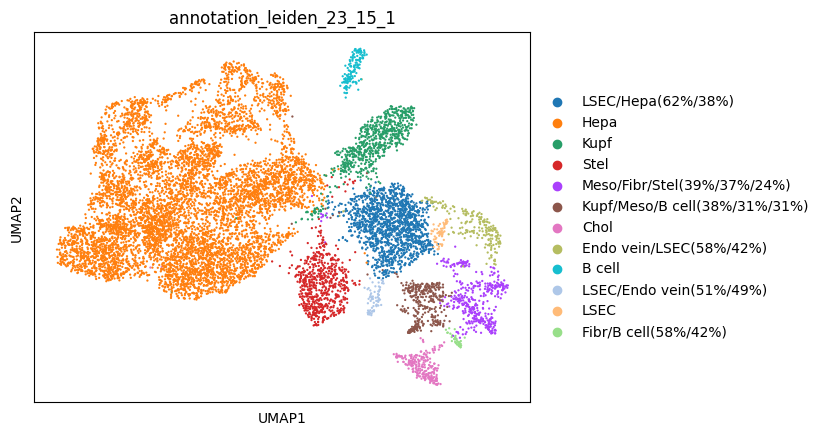

               atlas  annotation_leiden_23_15_1
B cell      0.621451                   1.327040
Chol        2.673310                   2.164232
Hepa       57.998500                  61.845387
Kupf        3.203686                   6.252227
LSEC        9.241401                   0.516566
Meso        2.796528                        NaN
Endo vein   3.166185                        NaN
Fibr        3.042966                        NaN
Stel       13.768349                   5.673317
Unknown     3.487625                  22.221233


,Hepa,LSEC,Endo vein,Chol,Kupf,Stel,Fibr,B cell,Meso
0,0.295484,0.482843,0.113675,0.047148,0.078107,0.111511,0.046796,0.003552,NaN
1,0.550029,0.003252,NaN,0.119755,NaN,NaN,NaN,0.000629,0.030956
2,0.904219,0.003528,0.008788,0.211904,0.024651,0.086014,0.062950,0.001388,0.042930
3,1.014885,NaN,0.009428,0.244556,0.042210,0.184855,0.135827,NaN,0.015170
4,0.902658,NaN,0.007077,0.208165,0.032742,0.093093,0.057237,0.000637,NaN
5,0.216939,0.111578,0.015578,NaN,1.181335,0.106381,0.062103,0.009039,0.016458
6,0.242958,0.035244,0.050244,NaN,0.115096,1.084494,0.631016,0.001669,0.059213
7,0.859246,NaN,0.007322,0.224020,0.027180,0.227757,0.082646,NaN,0.043615
8,0.648057,NaN,NaN,0.168699,NaN,0.141526,0.103666,NaN,0.052964
9,0.782869,0.004790,NaN,0.176393,NaN,0.096773,0.068014,NaN,0.048627


In [4]:
# With norm_expr_var = True and scale_score = Robust (q=1)
scores_leiden_celltype1 = make_umap_and_perform_leiden_annotation(sdata,path_mg,n_PCAs=n_pca,n_neighbors=n_neighb,cluster_resolution=n_clust_res)
suffix = '_' + str(n_pca) + '_' + str(n_neighb) + '_' + str(n_clust_res) 
suffix_short = '_' + str(n_pca) + '_' + str(n_neighb) 
path_mg = "/home/wout/Documents/Thesis_lokaal/Mouse_Liver_Resolve_Data/markerGeneListBasic.csv"
visualize_classification(sdata,'leiden'+suffix,'umap'+suffix_short,path_mg,cell_type_annotation=False,plot_dot_plot=False,plot_rank_genes_groups=False,plot_image=False)
print(sdata.table.uns['mapping_cell_type_leiden'+suffix])
visualize_classification(sdata,'annotation_leiden'+suffix,'umap'+suffix_short,path_mg,cell_type_annotation=True,plot_dot_plot=False,plot_rank_genes_groups=False,plot_image=False)
scores_leiden_celltype1

0.25


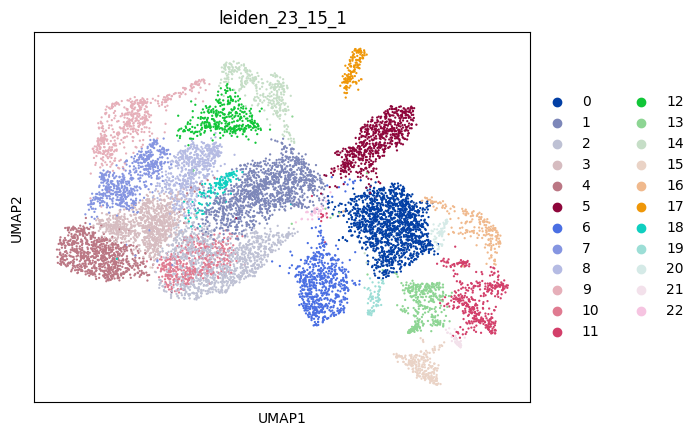

    leiden_23_15_1
0         0.126024
1         0.107143
2         0.097257
3         0.081315
4         0.073566
5         0.059227
6         0.056733
7         0.052547
8         0.051300
9         0.044888
10        0.037496
11        0.036961
12        0.032419
13        0.031439
14        0.028678
15        0.021642
16        0.018080
17        0.013270
18        0.011845
19        0.005967
20        0.005166
21        0.003741
22        0.003295
{'B cell': ['17'], 'Chol': ['15'], 'Endo vein/LSEC(58%/42%)': ['16'], 'Fibr/B cell/Meso(41%/31%/28%)': ['21'], 'Hepa': ['1', '2', '3', '4', '7', '8', '9', '10', '12', '14', '18'], 'Kupf': ['5', '22'], 'Kupf/Meso/B cell(36%/35%/29%)': ['13'], 'LSEC': ['0', '20'], 'LSEC/Endo vein(51%/49%)': ['19'], 'Meso/Fibr(52%/48%)': ['11'], 'Stel/Fibr(61%/39%)': ['6']}


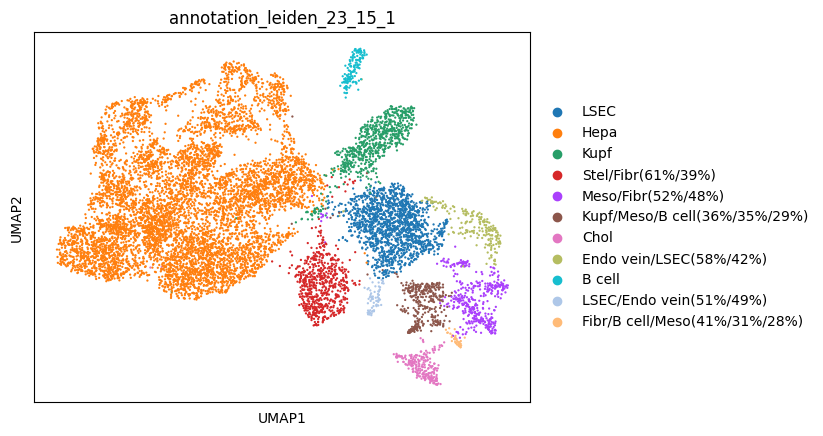

               atlas  annotation_leiden_23_15_1
B cell      0.621451                   1.327040
Chol        2.673310                   2.164232
Hepa       57.998500                  61.845387
Kupf        3.203686                   6.252227
LSEC        9.241401                  13.118988
Meso        2.796528                        NaN
Endo vein   3.166185                        NaN
Fibr        3.042966                        NaN
Stel       13.768349                        NaN
Unknown     3.487625                  15.292127


,Hepa,LSEC,Endo vein,Chol,Kupf,Stel,Fibr,B cell,Meso
0,0.294374,0.570182,0.131626,0.048585,0.079436,0.113981,0.052607,0.003680,NaN
1,0.550198,0.003759,NaN,0.127929,NaN,NaN,NaN,0.000673,0.027485
2,0.904366,0.004198,0.010118,0.226666,0.025392,0.089580,0.070367,0.001379,0.035033
3,1.014869,NaN,0.010687,0.261373,0.043164,0.186575,0.150381,NaN,NaN
4,0.903525,NaN,0.007936,0.222737,0.033764,0.096700,0.065089,0.000677,NaN
5,0.216068,0.132946,0.017621,NaN,1.181368,0.108480,0.069741,0.009306,0.016184
6,0.242364,0.039741,0.051006,NaN,0.115195,1.091195,0.707974,0.001785,0.055201
7,0.858716,NaN,0.008222,0.237695,0.027606,0.224259,0.090625,NaN,0.035880
8,0.647426,NaN,NaN,0.177120,NaN,0.142762,0.112540,NaN,0.046901
9,0.782177,0.005594,NaN,0.188145,NaN,0.098742,0.074048,NaN,0.043580


In [5]:
# With norm_expr_var = False and scale_score = Robust (q=1)
scores_leiden_celltype2 = make_umap_and_perform_leiden_annotation(sdata,path_mg,n_PCAs=n_pca,n_neighbors=n_neighb,cluster_resolution=n_clust_res,norm_expr_var=False)
suffix = '_' + str(n_pca) + '_' + str(n_neighb) + '_' + str(n_clust_res) 
suffix_short = '_' + str(n_pca) + '_' + str(n_neighb) 
path_mg = "/home/wout/Documents/Thesis_lokaal/Mouse_Liver_Resolve_Data/markerGeneListBasic.csv"
visualize_classification(sdata,'leiden'+suffix,'umap'+suffix_short,path_mg,cell_type_annotation=False,plot_dot_plot=False,plot_rank_genes_groups=False,plot_image=False)
print(sdata.table.uns['mapping_cell_type_leiden'+suffix])
visualize_classification(sdata,'annotation_leiden'+suffix,'umap'+suffix_short,path_mg,cell_type_annotation=True,plot_dot_plot=False,plot_rank_genes_groups=False,plot_image=False)
scores_leiden_celltype2

0.25


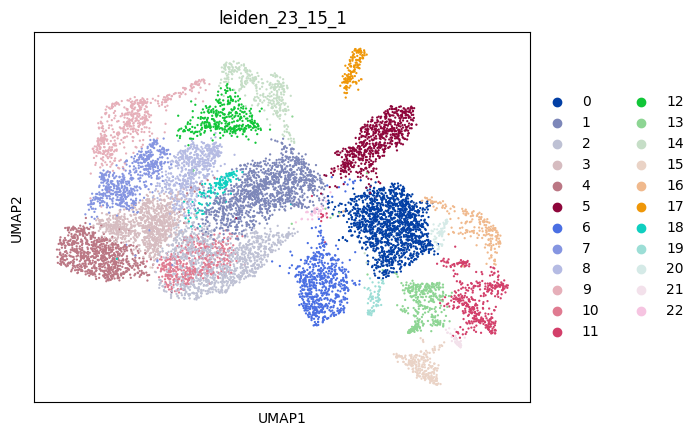

    leiden_23_15_1
0         0.126024
1         0.107143
2         0.097257
3         0.081315
4         0.073566
5         0.059227
6         0.056733
7         0.052547
8         0.051300
9         0.044888
10        0.037496
11        0.036961
12        0.032419
13        0.031439
14        0.028678
15        0.021642
16        0.018080
17        0.013270
18        0.011845
19        0.005967
20        0.005166
21        0.003741
22        0.003295
{'B cell': ['17'], 'Chol': ['15'], 'Endo vein/LSEC(58%/42%)': ['16'], 'Fibr/B cell/Stel(44%/29%/27%)': ['21'], 'Fibr/Meso/Stel(38%/38%/25%)': ['11'], 'Hepa': ['1', '2', '3', '4', '7', '8', '9', '10', '12', '14', '18'], 'Kupf': ['5', '22'], 'Kupf/Meso/B cell(38%/32%/30%)': ['13'], 'LSEC': ['20'], 'LSEC/Endo vein(50%/50%)': ['19'], 'LSEC/Hepa(59%/41%)': ['0'], 'Stel': ['6']}


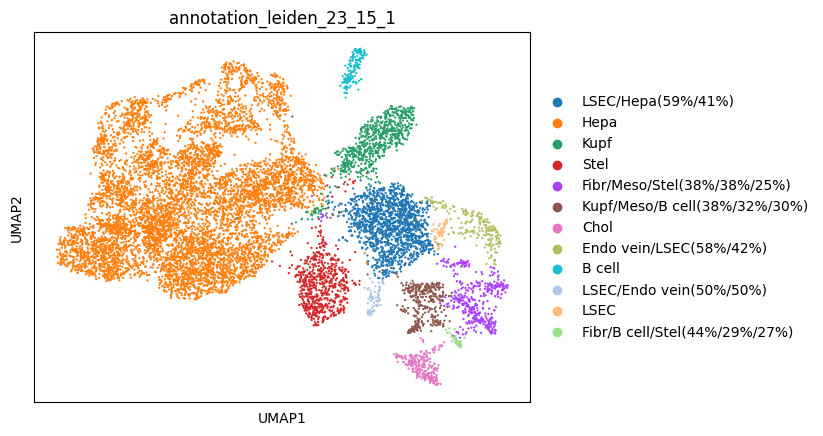

               atlas  annotation_leiden_23_15_1
B cell      0.621451                   1.327040
Chol        2.673310                   2.164232
Hepa       57.998500                  61.845387
Kupf        3.203686                   6.252227
LSEC        9.241401                   0.516566
Meso        2.796528                        NaN
Endo vein   3.166185                        NaN
Fibr        3.042966                        NaN
Stel       13.768349                   5.673317
Unknown     3.487625                  22.221233


,Hepa,LSEC,Endo vein,Chol,Kupf,Stel,Fibr,B cell,Meso
0,0.298690,0.427510,0.103279,0.041213,0.066885,0.111843,0.047357,0.003002,NaN
1,0.546834,0.002932,NaN,0.100921,NaN,NaN,NaN,0.000550,0.027095
2,0.892117,0.003176,0.008136,0.176699,0.021672,0.088568,0.061912,0.001187,0.037575
3,1.000000,NaN,0.008716,0.203550,0.036523,0.178792,0.127577,NaN,0.013278
4,0.890595,NaN,0.006584,0.173624,0.028515,0.095030,0.056764,0.000557,NaN
5,0.222120,0.098832,0.014295,NaN,1.000000,0.107160,0.061149,0.007603,0.014405
6,0.247485,0.031254,0.045740,NaN,0.098171,1.000000,0.573760,0.001423,0.051827
7,0.848275,NaN,0.006806,0.186662,0.023811,0.217954,0.079659,NaN,0.038174
8,0.642397,NaN,NaN,0.141170,NaN,0.139241,0.098599,NaN,0.046358
9,0.773819,0.004293,NaN,0.147497,NaN,0.098389,0.066475,NaN,0.042562


In [6]:
# With norm_expr_var = True and scale_score = MinMax
scores_leiden_celltype = make_umap_and_perform_leiden_annotation(sdata,path_mg,n_PCAs=n_pca,n_neighbors=n_neighb,cluster_resolution=n_clust_res,scale_score='MinMax')
suffix = '_' + str(n_pca) + '_' + str(n_neighb) + '_' + str(n_clust_res) 
suffix_short = '_' + str(n_pca) + '_' + str(n_neighb) 
path_mg = "/home/wout/Documents/Thesis_lokaal/Mouse_Liver_Resolve_Data/markerGeneListBasic.csv"
visualize_classification(sdata,'leiden'+suffix,'umap'+suffix_short,path_mg,cell_type_annotation=False,plot_dot_plot=False,plot_rank_genes_groups=False,plot_image=False)
print(sdata.table.uns['mapping_cell_type_leiden'+suffix])
visualize_classification(sdata,'annotation_leiden'+suffix,'umap'+suffix_short,path_mg,cell_type_annotation=True,plot_dot_plot=False,plot_rank_genes_groups=False,plot_image=False)
scores_leiden_celltype

0.25


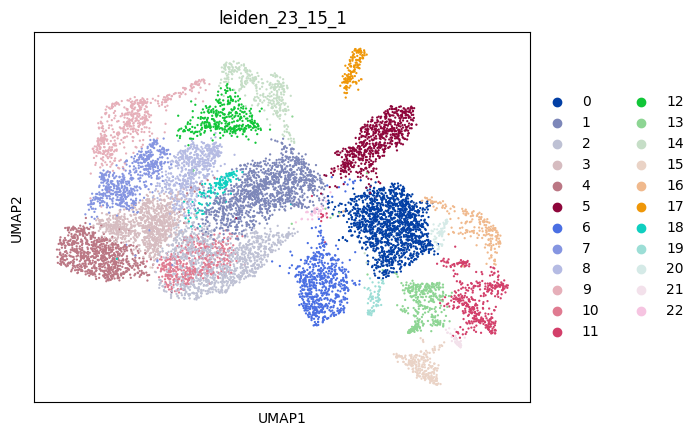

    leiden_23_15_1
0         0.126024
1         0.107143
2         0.097257
3         0.081315
4         0.073566
5         0.059227
6         0.056733
7         0.052547
8         0.051300
9         0.044888
10        0.037496
11        0.036961
12        0.032419
13        0.031439
14        0.028678
15        0.021642
16        0.018080
17        0.013270
18        0.011845
19        0.005967
20        0.005166
21        0.003741
22        0.003295
{'B cell': ['17'], 'B cell/LSEC/Kupf(5%/46%/49%)': ['22'], 'Chol': ['15'], 'Endo vein': ['16'], 'Endo vein/LSEC(55%/45%)': ['19'], 'Fibr': ['11', '21'], 'Hepa': ['2', '3', '4', '7', '8', '9', '10', '12', '14', '18'], 'Kupf': ['5'], 'Kupf/B cell(60%/40%)': ['13'], 'LSEC': ['0', '20'], 'Meso/Hepa/B cell(23%/36%/41%)': ['1'], 'Stel/Fibr(60%/40%)': ['6']}


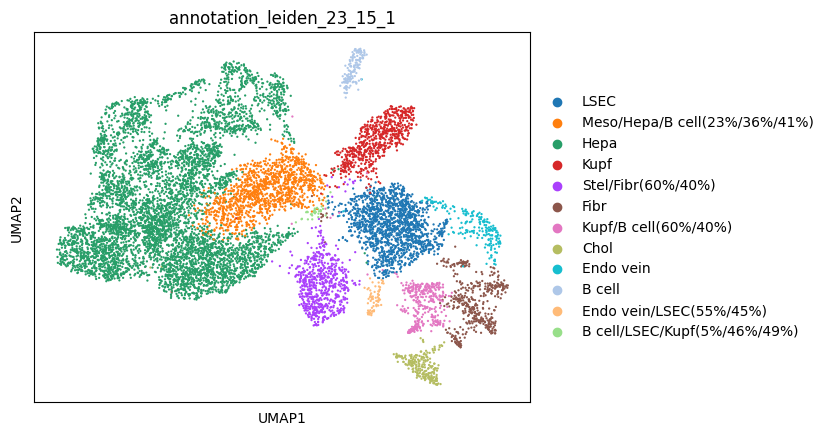

               atlas  annotation_leiden_23_15_1
B cell      0.621451                   1.327040
Chol        2.673310                   2.164232
Hepa       57.998500                  51.131101
Kupf        3.203686                   5.922693
LSEC        9.241401                  13.118988
Meso        2.796528                        NaN
Endo vein   3.166185                   1.807980
Fibr        3.042966                   4.070182
Stel       13.768349                        NaN
Unknown     3.487625                  20.457784


,Hepa,LSEC,Endo vein,Chol,Kupf,Stel,Fibr,B cell,Meso
0,-3.460093,10.989380,2.278675,-1.790231,-1.301024,-1.822716,-2.907918,-0.432275,NaN
1,-0.427371,-2.828320,NaN,-0.586995,NaN,NaN,NaN,-0.482294,-0.268901
2,3.792530,-2.820380,-1.384843,0.940080,-2.826036,-2.437137,-2.427748,-0.469303,-0.219206
3,5.111039,NaN,-1.362488,1.481186,-2.325098,-0.055361,-0.261462,NaN,-0.334417
4,3.773936,NaN,-1.444598,0.878113,-2.595199,-2.266554,-2.597574,-0.482150,NaN
5,-4.395898,0.292705,-1.147669,NaN,30.171808,-1.946341,-2.452922,-0.338389,-0.329075
6,-4.085902,-1.906594,0.063132,NaN,-0.245806,21.623266,14.458159,-0.464492,-0.151628
7,3.256718,NaN,-1.436028,1.140859,-2.753880,0.978454,-1.842269,NaN,-0.216365
8,0.740560,NaN,NaN,0.224099,NaN,-1.099450,-1.217452,NaN,-0.177561
9,2.346745,-2.784031,NaN,0.351591,NaN,-2.177873,-2.277228,NaN,-0.195563


In [7]:
# With norm_expr_var = True and scale_score = None
scores_leiden_celltype = make_umap_and_perform_leiden_annotation(sdata,path_mg,n_PCAs=n_pca,n_neighbors=n_neighb,cluster_resolution=n_clust_res,scale_score='None')
suffix = '_' + str(n_pca) + '_' + str(n_neighb) + '_' + str(n_clust_res) 
suffix_short = '_' + str(n_pca) + '_' + str(n_neighb) 
path_mg = "/home/wout/Documents/Thesis_lokaal/Mouse_Liver_Resolve_Data/markerGeneListBasic.csv"
visualize_classification(sdata,'leiden'+suffix,'umap'+suffix_short,path_mg,cell_type_annotation=False,plot_dot_plot=False,plot_rank_genes_groups=False,plot_image=False)
print(sdata.table.uns['mapping_cell_type_leiden'+suffix])
visualize_classification(sdata,'annotation_leiden'+suffix,'umap'+suffix_short,path_mg,cell_type_annotation=True,plot_dot_plot=False,plot_rank_genes_groups=False,plot_image=False)
scores_leiden_celltype

0.25


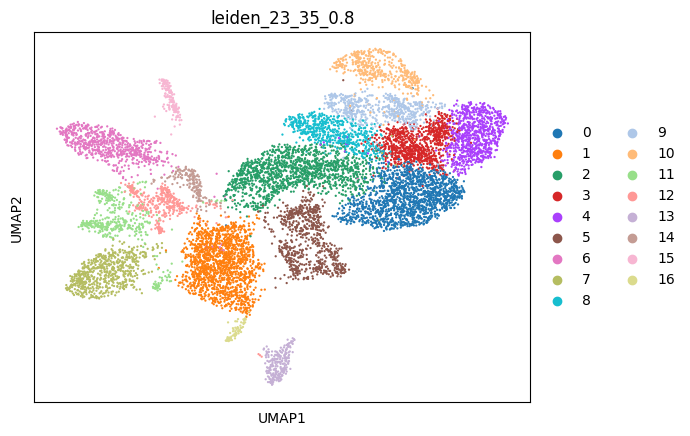

    leiden_23_35_0.8
0           0.135910
1           0.133684
2           0.122105
3           0.082561
4           0.074724
5           0.063858
6           0.060029
7           0.055843
8           0.052636
9           0.050410
10          0.040702
11          0.037317
12          0.035002
13          0.021375
14          0.014784
15          0.013092
16          0.005967
{'B cell': ['15'], 'Chol': ['13'], 'Endo vein/LSEC(61%/39%)': ['14'], 'Hepa': ['0', '2', '3', '4', '5', '8', '9', '10'], 'Kupf': ['6'], 'Kupf/Meso/B cell(38%/31%/31%)': ['12'], 'LSEC': ['1'], 'LSEC/Endo vein(51%/49%)': ['16'], 'Meso/Fibr/Stel(39%/38%/24%)': ['11'], 'Stel': ['7']}


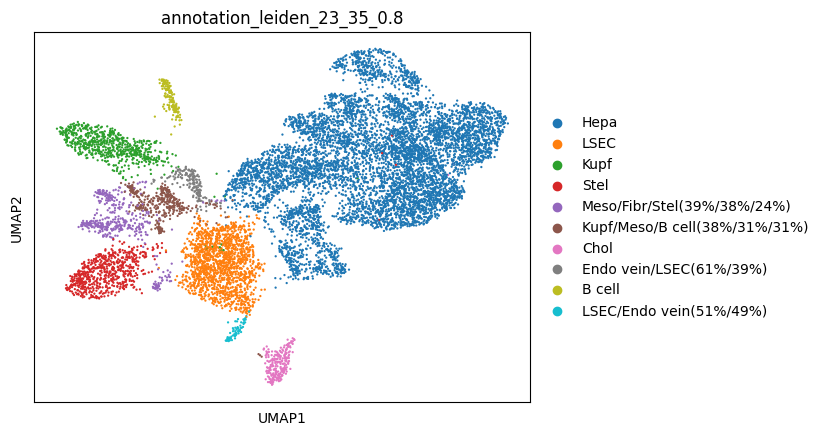

               atlas  annotation_leiden_23_35_0.8
B cell      0.621451                     1.309227
Chol        2.673310                     2.137513
Hepa       57.998500                    62.290702
Kupf        3.203686                     6.002850
LSEC        9.241401                    13.368365
Meso        2.796528                          NaN
Endo vein   3.166185                          NaN
Fibr        3.042966                          NaN
Stel       13.768349                     5.584254
Unknown     3.487625                     9.307089


,Hepa,LSEC,Endo vein,Chol,Kupf,Stel,Fibr,B cell,Meso
0,0.909775,0.003039,0.006327,0.194086,0.036009,NaN,0.032015,0.001005,0.026714
1,0.259318,0.475425,0.112720,NaN,0.071881,0.084513,NaN,0.003589,NaN
2,0.509159,NaN,NaN,0.100935,NaN,NaN,NaN,0.000723,0.026560
3,1.017186,NaN,0.007061,0.223486,0.039059,0.160670,0.107747,NaN,NaN
4,0.892402,NaN,0.004885,0.187942,0.029033,NaN,0.027256,NaN,NaN
5,0.840542,0.004772,NaN,0.055142,NaN,NaN,NaN,NaN,0.095912
6,NaN,0.107140,0.012709,NaN,1.126697,0.081772,0.033771,0.008717,NaN
7,0.204098,0.033744,0.047259,NaN,0.106732,1.062652,0.609632,0.001912,0.052203
8,0.628492,NaN,NaN,0.149691,NaN,0.113930,0.074067,NaN,0.043749
9,0.836877,NaN,NaN,0.198685,NaN,0.196035,0.050057,NaN,0.037654


In [8]:
# other good parameters for n_neighbors and cluster_resolution
n_neighb = 35    
n_clust_res = 0.8
scores = make_umap_and_perform_leiden_annotation(sdata,path_mg,n_PCAs=n_pca,n_neighbors=n_neighb,cluster_resolution=n_clust_res)
suffix = '_' + str(n_pca) + '_' + str(n_neighb) + '_' + str(n_clust_res) 
suffix_short = '_' + str(n_pca) + '_' + str(n_neighb) 
path_mg = "/home/wout/Documents/Thesis_lokaal/Mouse_Liver_Resolve_Data/markerGeneListBasic.csv"
visualize_classification(sdata,'leiden'+suffix,'umap'+suffix_short,path_mg,cell_type_annotation=False,plot_dot_plot=False,plot_rank_genes_groups=False,plot_image=False)
print(sdata.table.uns['mapping_cell_type_leiden'+suffix])
visualize_classification(sdata,'annotation_leiden'+suffix,'umap'+suffix_short,path_mg,cell_type_annotation=True,plot_dot_plot=False,plot_rank_genes_groups=False,plot_image=False)
scores